In [1]:
# SENSYN - Sentence Synonymity using a Neural Network and Decision tree

import nltk
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
nlp = spacy.load('en_core_web_sm')

In [2]:
#Synset data structure
class SynsetStruct():
    def __init__(self, words):
        self.words = words
        self.synsets = []
        for iword in self.words:
            self.synsets.append(wn.synsets(iword))

#Feature extraction class
class FeatureExtraction:
    def __init__(self, sentence):
        self.sentence = sentence
        self.wordlist = word_tokenize(self.sentence)

    def removeStopWords(self):
        self.wordlist = [word for word in self.wordlist if word not in stopwords.words('english')]

    def getWordList(self):
        return self.wordlist

    def getPosTags(self):
        return nltk.pos_tag(self.wordlist)

    def getDependencyParseTree(self):
        return nlp(self.sentence)

    def getLemmas(self):
        doc = nlp(self.sentence)
        LemmaList = []
        for wordx in doc:
            LemmaList.append(wordx.lemma_)
        return LemmaList

    def getSynsets(self):
        syn = SynsetStruct(self.wordlist)
        return syn

    def getActiveOrPassive(self):
        beforms = ['am', 'is', 'are', 'been', 'was', 'were', 'be', 'being']
        aux = ['do', 'did', 'does', 'have', 'has', 'had']
        tokens = nltk.pos_tag(self.wordlist)
        tags = [i[1] for i in tokens]
        if tags.count('VBN') == 0:
            return "Active"
        elif tags.count('VBN') == 1 and 'been' in self.wordlist:
            return "Active"
        else:
            pos = [i for i in range(len(tags)) if tags[i] == 'VBN' and self.wordlist[i] != 'been']
            for end in pos:
                chunk = tags[:end]
                start = 0
                for i in range(len(chunk), 0, -1):
                    last = chunk.pop()
                    if last == 'NN' or last == 'PRP':
                        start = i
                        break
                sentchunk = self.wordlist[start:end]
                tagschunk = tags[start:end]
                verbspos = [i for i in range(len(tagschunk)) if tagschunk[i].startswith('V')]
                if verbspos != []:
                    for i in verbspos:
                        if sentchunk[i].lower() not in beforms and sentchunk[i].lower() not in aux:
                            break
                    else:
                        return "Passive"
        return "Active"

In [3]:
import pandas as pd
train_df = pd.read_csv("C:/Users/sidro/OneDrive/Documents/Grad/Course work/Semester 1/NLP/Project work/train-set.txt", delimiter='\t+', error_bad_lines = False)
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print(train_df)
test_df = pd.read_csv("C:/Users/sidro/OneDrive/Documents/Grad/Course work/Semester 1/NLP/Project work/dev-set.txt", delimiter='\t+', error_bad_lines = False)
test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print(test_df)

          id                                          sentence1  \
0        s_1  But other sources close to the sale said Viven...   
1        s_2  Micron has declared its first quarterly profit...   
2        s_3  The fines are part of failed Republican effort...   
3        s_4  The American Anglican Council, which represent...   
4        s_5  The tech-loaded Nasdaq composite rose 20.96 po...   
...      ...                                                ...   
1479  s_1480  Action is needed quickly, which is why we deci...   
1480  s_1481  One could indeed wish for more and for improve...   
1481  s_1482           (Parliament accepted the oral amendment)   
1482  s_1483  - My party has serious reservations about Comm...   
1483  s_1484                                 He saw a red rose.   

                                              sentence2  gold_tag  
0     But other sources close to the sale said Viven...         4  
1     Micron's numbers also marked the first quarter...    

C:\Users\sidro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\sidro\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [4]:
from operator import eq
pWordsSame = []
pWordsLem = []
sTagSeq = []
sActPas = []
rSame = []
rSameLem = []
rPOS = []
rHypo = []
rMero = []
rHolo = []
rHyper = []
for index,row in train_df.iterrows():
    sent1 = row['sentence1']
    sent2 = row['sentence2']
    f1 = FeatureExtraction(str(sent1))
    f2 = FeatureExtraction(str(sent2))
    pos1 = f1.getPosTags()
    pos2 = f2.getPosTags()
    if pos1 == pos2 :
        sTagSeq.append(1.0)
    else:
        sTagSeq.append(0.0)
    if f1.getActiveOrPassive() == f2.getActiveOrPassive() :
        sActPas.append(1.0)
    else:
        sActPas.append(0.0)
    dep1 = f1.getDependencyParseTree()
    dep2 = f2.getDependencyParseTree()
    root1 = [token for token in dep1 if token.head == token][0]
    root2 = [token for token in dep2 if token.head == token][0]
    if str(root1.tag_) == str(root2.tag_) :
        rPOS.append(1.0)
    else:
        rPOS.append(0.0)
    if str(root1) == str(root2) :
        rSame.append(1.0)
    else:
        rSame.append(0.0)
    temp = nlp(str(root1))
    for t in temp:
        root1lem = t.lemma_
    temp = nlp(str(root2))
    for t in temp:
        root2lem = t.lemma_
    if str(root1lem) == str(root2lem) :
        rSameLem.append(1.0)
    else:
        rSameLem.append(0.0)
    f1.removeStopWords()
    f2.removeStopWords()
    words1 = f1.getWordList()
    words2 = f2.getWordList()
    cCommonWords = len(list(set(words1).intersection(words2)))
    pWordsSame.append(round((2 * cCommonWords)/(len(words1)+len(words2)),2))
    lemms1 = f1.getLemmas()
    lemms2 = f2.getLemmas()
    cCommonLemms = len(list(set(lemms1).intersection(lemms2)))
    pWordsLem.append(round((2 * cCommonLemms)/(len(lemms1)+len(lemms2)),2))
train_df['pWordsSame'] = pWordsSame
train_df['pWordsLem'] = pWordsLem
train_df['sTagSeq'] = sTagSeq
train_df['sActPas'] = sActPas
train_df['rSame'] = rSame
train_df['rSameLem'] = rSameLem
train_df['rPOS'] = rPOS
print(train_df)

          id                                          sentence1  \
0        s_1  But other sources close to the sale said Viven...   
1        s_2  Micron has declared its first quarterly profit...   
2        s_3  The fines are part of failed Republican effort...   
3        s_4  The American Anglican Council, which represent...   
4        s_5  The tech-loaded Nasdaq composite rose 20.96 po...   
...      ...                                                ...   
1479  s_1480  Action is needed quickly, which is why we deci...   
1480  s_1481  One could indeed wish for more and for improve...   
1481  s_1482           (Parliament accepted the oral amendment)   
1482  s_1483  - My party has serious reservations about Comm...   
1483  s_1484                                 He saw a red rose.   

                                              sentence2  gold_tag  pWordsSame  \
0     But other sources close to the sale said Viven...         4        0.69   
1     Micron's numbers also marke

In [5]:
pWordsSame = []
pWordsLem = []
sTagSeq = []
sActPas = []
rSame = []
rSameLem = []
rPOS = []
rHypo = []
rMero = []
rHolo = []
rHyper = []

for index,row in test_df.iterrows():
    sent1 = row['sentence1']
    sent2 = row['sentence2']
    f1 = FeatureExtraction(str(sent1))
    f2 = FeatureExtraction(str(sent2))
    pos1 = f1.getPosTags()
    pos2 = f2.getPosTags()
    if pos1 == pos2 :
        sTagSeq.append(1.0)
    else:
        sTagSeq.append(0.0)
    if f1.getActiveOrPassive() == f2.getActiveOrPassive() :
        sActPas.append(1.0)
    else:
        sActPas.append(0.0)
    dep1 = f1.getDependencyParseTree()
    dep2 = f2.getDependencyParseTree()
    root1 = [token for token in dep1 if token.head == token][0]
    root2 = [token for token in dep2 if token.head == token][0]
    if str(root1.tag_) == str(root2.tag_) :
        rPOS.append(1.0)
    else:
        rPOS.append(0.0)
    if str(root1) == str(root2) :
        rSame.append(1.0)
    else:
        rSame.append(0.0)
    temp = nlp(str(root1))
    for t in temp:
        root1lem = t.lemma_
    temp = nlp(str(root2))
    for t in temp:
        root2lem = t.lemma_
    if str(root1lem) == str(root2lem) :
        rSameLem.append(1.0)
    else:
        rSameLem.append(0.0)
    f1.removeStopWords()
    f2.removeStopWords()
    words1 = f1.getWordList()
    words2 = f2.getWordList()
    cCommonWords = len(list(set(words1).intersection(words2)))
    pWordsSame.append(round((2 * cCommonWords)/(len(words1)+len(words2)),2))
    lemms1 = f1.getLemmas()
    lemms2 = f2.getLemmas()
    cCommonLemms = len(list(set(lemms1).intersection(lemms2)))
    pWordsLem.append(round((2 * cCommonLemms)/(len(lemms1)+len(lemms2)),2))
test_df['pWordsSame'] = pWordsSame
test_df['pWordsLem'] = pWordsLem
test_df['sTagSeq'] = sTagSeq
test_df['sActPas'] = sActPas
test_df['rSame'] = rSame
test_df['rSameLem'] = rSameLem
test_df['rPOS'] = rPOS

In [6]:
import tensorflow as tf
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.models import Sequential
from keras.layers import Dense
X = train_df[['pWordsSame','pWordsLem','sTagSeq','sActPas','rSame','rSameLem','rPOS']]
print(X)
y = train_df[['gold_tag']]
y.gold_tag = y.gold_tag/5
print(y)
for index,row in X.iterrows():
    if row['pWordsLem']>0.52 :
        row['pWordsLem'] = 1
    else:
        row['pWordsLem'] = 0
    if row['pWordsSame']>0.52 :
        row['pWordsSame'] = 1
    else:
        row['pWordsSame'] = 0

C:\Users\sidro\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sidro\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sidro\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sidro\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi





      pWordsSame  pWordsLem  sTagSeq  sActPas  rSame  rSameLem  rPOS
0           0.69       0.64      0.0      1.0    1.0       1.0   1.0
1           0.67       0.57      0.0      0.0    0.0       0.0   0.0
2           0.48       0.43      0.0      1.0    0.0       0.0   0.0
3           0.74       0.75      0.0      1.0    1.0       1.0   1.0
4           0.31       0.33      0.0      1.0    0.0       0.0   1.0
...          ...        ...      ...      ...    ...       ...   ...
1479        0.50       0.61      0.0      1.0    0.0       0.0   0.0
1480        0.48       0.52      0.0      0.0    0.0       0.0   1.0
1481        1.00       0.93      1.0      1.0    1.0       1.0   1.0
1482        0.69       0.54      0.0      1.0    0.0       0.0   0.0
1483        0.55       0.62      0.0      1.0    0.0       0.0   1.0

[1484 rows x 7 columns]
      gold_tag
0          0.8
1          0.8
2          0.6
3          0.6
4          0.4
...        ...
1479       1.0
1480       1.0
1481    

C:\Users\sidro\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
model = Sequential()
model.add(Dense(1, input_dim=7, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, batch_size=5)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
1484/1484 [==============================] - 2s 2ms/step - loss: 0.8962 - acc: 0.0586
Epoch 2/200
1484/1484 [==============================] - 1s 579us/step - loss: 0.6390 - acc: 0.2136
Epoch 3/200
1484/1484 [==============================] - 1s 579us/step - loss: 0.5742 - acc: 0.2722
Epoch 4/200
1484/1484 [==============================] - 1s 585us/step - loss: 0.5567 - acc: 0.2817
Epoch 5/200
1484/1484 [==============================] - 1s 586us/step - loss: 0.5489 - acc: 0.2817
Epoch 6/200
1484/1484 [==============================] - 1s 580us/step - loss: 0.5433 - acc: 0.2817
Epoch 7/200
1484/1484 [==============================] - 1s 573us/step - loss: 0.5390 - acc: 0.2817
Epoch 8/200
1484/1484 [==============================] - 1s 582us/step - loss: 0.5356 - acc: 0.2817
Epoch 9/200
1484/1484 [==============================] - 1s 582us/step - loss: 0.5332 - acc: 0.2817
Epoch 

1484/1484 [==============================] - 1s 373us/step - loss: 0.5258 - acc: 0.2817
Epoch 76/200
1484/1484 [==============================] - 1s 364us/step - loss: 0.5259 - acc: 0.2817
Epoch 77/200
1484/1484 [==============================] - 1s 376us/step - loss: 0.5258 - acc: 0.2817
Epoch 78/200
1484/1484 [==============================] - 1s 370us/step - loss: 0.5257 - acc: 0.2817
Epoch 79/200
1484/1484 [==============================] - 1s 367us/step - loss: 0.5259 - acc: 0.2817
Epoch 80/200
1484/1484 [==============================] - 1s 368us/step - loss: 0.5259 - acc: 0.2817
Epoch 81/200
1484/1484 [==============================] - 1s 376us/step - loss: 0.5258 - acc: 0.2817
Epoch 82/200
1484/1484 [==============================] - 1s 368us/step - loss: 0.5258 - acc: 0.2817
Epoch 83/200
1484/1484 [==============================] - 1s 378us/step - loss: 0.5258 - acc: 0.2817
Epoch 84/200
1484/1484 [==============================] - 1s 388us/step - loss: 0.5258 - acc: 0.2817
Epo

In [8]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

C:\Users\sidro\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [13]:
for index,row in X.iterrows():
    if row['pWordsLem']>0.52 :
        row['pWordsLem'] = 1
    else:
        row['pWordsLem'] = 0
    if row['pWordsSame']>0.52 :
        row['pWordsSame'] = 1
    else:
        row['pWordsSame'] = 0

y = train_df[['gold_tag']]
X_t = test_df[['pWordsSame','pWordsLem','sTagSeq','sActPas','rSame','rSameLem','rPOS']]
for index,row in X_t.iterrows():
    if row['pWordsLem']>0.52 :
        row['pWordsLem'] = 1
    else:
        row['pWordsLem'] = 0
    if row['pWordsSame']>0.52 :
        row['pWordsSame'] = 1
    else:
        row['pWordsSame'] = 0
print(X_t)
y_t = test_df[['gold_tag']]
print(y_t)
#Xx = X[['pWordsSame']]
#Xxt = X_t[['pWordsSame']]
clf = DecisionTreeClassifier()
clf = clf.fit(X,y)

      pWordsSame  pWordsLem  sTagSeq  sActPas  rSame  rSameLem  rPOS
0            0.0        0.0      0.0      0.0    0.0       0.0   0.0
1            1.0        1.0      0.0      1.0    0.0       1.0   0.0
2            0.0        0.0      0.0      1.0    0.0       0.0   1.0
3            1.0        1.0      0.0      1.0    1.0       1.0   1.0
4            1.0        1.0      1.0      1.0    1.0       1.0   1.0
...          ...        ...      ...      ...    ...       ...   ...
1204         1.0        1.0      0.0      1.0    0.0       0.0   1.0
1205         1.0        1.0      0.0      0.0    0.0       0.0   0.0
1206         0.0        0.0      0.0      0.0    1.0       1.0   0.0
1207         0.0        0.0      0.0      1.0    1.0       1.0   1.0
1208         0.0        0.0      0.0      1.0    0.0       0.0   0.0

[1209 rows x 7 columns]
      gold_tag
0            5
1            5
2            4
3            5
4            5
...        ...
1204         3
1205         3
1206        

In [14]:
y_pred = clf.predict(X_t)
print("Accuracy:",metrics.accuracy_score(y_t, y_pred))

Accuracy: 0.3283705541770058


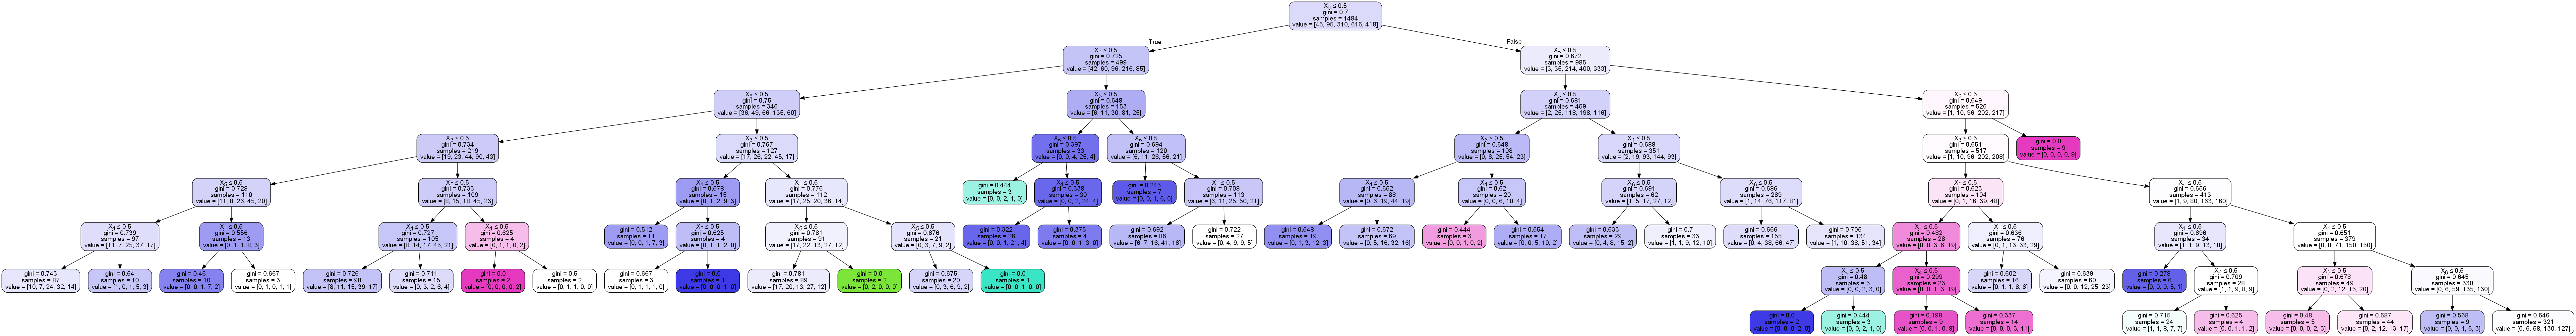

In [15]:
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())